In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Tema 3b: Delo z zapisi s fiksno dolžino

Podatki za statistične analize so velikokrat dostopni v obliki besedilnih datatotek (.txt ali .csv). Vrstice v datotekah so lahko fiksne ali variabilne dolžine. V prvem primeru vrstico razdelimo na posamične vrednosti glede na začetno in končno pozicijo podatka znotraj vrstice. V drugem primeru pa celotno vrstico razcepimo na posamične vrednosti glede na uporabljen delimiter. 

Knjižnica`pandas` omogoča samodejno prepoznavo podatkov v vrstici oziroma celotni datoteki. Spoznali bomo tri načine branja podatkov v besedilnih datotekah. Brali bomo iz datotek s fiksno širino stolpcev, iz datotek v katerih so podatki ločeni z delimiterjem in iz JSON datotek. Po branju podatkov bomo preverili, ali so funkcije pravilno prepoznale strukturo in tip podatkov in po potrebi izvedli tudi popravke. Podatke več datotek bomo združevali in na koncu shranili v izhodno besedilno datoteko. V tem poglavju bomo brali datoteke s fiksno širino stolpcev.

Kaj bomo naredili?

- Seznanili se bomo s podatki števcev prometa na slovenskem cestnem omrežju.
- Naložili bomo podatke iz več vhodnih datotek in jih združili v skupno tabelo.
- Podatke bomo prečistili za potrebe analize.
- Izvedli bomo agregacijo podatkov glede na različne kriterije.
- Podatke bomo prikazali v tabelarični obliki.
- Podatke bomo prikazali v grafih.

Spoznali se bomo z uporabo naslednjih funkcionalnosti:
- funkcija `read_fwf()` - branje besedilnih datotek s fiksno širino stolpcev
- atribut `columns` - določanje imen stolpcev v `pandas.DataFrame`
- funkcija `drop` - opuščanje stolpcev, ki jih ne potrebujemo
- priprava izračunljivih vrednosti za celoten stolpec
- knjižnica `io` za dostop do datotek
- funkcija `read_csv`: branje besedilnih datotek s stolpci ločenimi z delimiterjem
- funkcija `read_json`: branje datotek strukturiranih v formatu JSON
- določanje in opuščanje indeksov tabele
- iskanje vrstic z indeksi in `loc[]`
- funkcija `query()`: iskanje vrstic po vrednosti stolpca 
- funkcija `map()`: preslikave vrednosti z uporabo slovarjev 
- funkcija `notnull()` in delo z manjkajočimi podatki
- funkcija `groupby()` in agregiranje podatkov znotraj tabele
- funkcija `crosstab()`, vrtilne tabele in uporaba agregatnih funkcij
- shranjevanje v format csv
- hitri prikazi in pvezave s funkcionalnostmi `matplotlib`


## Podatki števcev prometa

### Pregled podatkov števca

Podatki o štetju prometa so zapisani v besedilno datoteko fiksne širine stolpcev. Za vsak števec so podatki zapisani v svojo datoteko, ki zajema podatke za eno leto. Vrstica datoteke opisuje števčno stanje za en dan.

Za leto 2005 imamo datoteke shranjene v mapi __stevci_2005__, pri zapisu podatkov je bila uporabljena kodna tabela __cp1250__.


In [119]:
mapa = 'stevci_2005'

#primer datoteke števca 10 za leto 2005
ime_dat = 'AVTP_00010_2005_01_01__00_00-2005_12_31__23_50.A_D'


Za prvi vtis o podatkih izpišemo prvih 30 vrstic datoteke. Vrstice oštevilčimo zaradi preglednosti. Ne pozabimo, da ima vsaka vrstica na koncu znak za preskok v novo vrsto, zato v funkciji `print()` izklopimo samodejno dodajanje preskoka v novo vrsto.

In [122]:
pot = f'{mapa}/{ime_dat}' 
with open(pot, encoding='cp1250') as f:
    for i, v in enumerate(f):
        print(f'{i}: {v}', end='')
        if i == 30:
            break

0: DIREKCIJA REPUBLIKE SLOVENIJE ZA CESTE, Tržaška 19, 1000 Ljubljana
1: Dnevni podatki
2: Prometni odsek: 02391 VALETA-SEČOVLJE  /  Števno mesto: 10 Seča  /  Vhodna STM: 10  /  Tip števca: QLD6
3: Smer 1: VALETA - SEČOVLJE
4: Smer 2: SEČOVLJE - VALETA
5: Za čas od     01/01/2005   00:00     do      31/12/2005   23:50
6: Čas izdelave: 22/05/2006    16:15
7: Polovični števec: ne      
8:  
9:  
10: POVPREČNI DNEVNI PROMET OBDOBJA                                    :        9569
11: POVPREČNI DNEVNI PROMET OBDOBJA ZA MO - MOTORNA VOZILA             :         107
12: POVPREČNI DNEVNI PROMET OBDOBJA ZA OA - OSEBNA VOZILA              :        8909
13: POVPREČNI DNEVNI PROMET OBDOBJA ZA BUS - AVTOBUSE                  :          55
14: POVPREČNI DNEVNI PROMET OBDOBJA ZA LT - LAHKA TOVORNA VOZILA       :         370
15: POVPREČNI DNEVNI PROMET OBDOBJA ZA ST - SRED. TOVORNA VOZILA       :          75
16: POVPREČNI DNEVNI PROMET OBDOBJA ZA TT - TEŽKA TOVORNA VOZILA       :          35
17: POVP

Prvih nekaj vrstic datoteke predstavlja glavo datoteke in se po vsebini razlikuje od vrstic s podaki, ki nas dejansko zanimajo. Podatki o stanju števca za posamezen dan se v tem primeru pričnejo v 24 vrstici. Vrstice od 1 do 24 želimo pri branju preskočiti, saj jih ne potrebujemo.

Podatke bomo brali iz več vhodnih datotek, morda za vse ne velja, da se tabela s podatki začne v 24 vrstici. Zato bi bilo dobro, da najprej programsko preverimo, kje se v posamični datoteki podatki dejansko pričnejo. Izmeriti želimo dolžino glave datoteke.  

V ta namen bomo pripravili funkcijo, ki izmeri dolžino glave za datoteko, katere ime bomo funkciji posredovali kot parameter:

In [125]:
def dolzina_glave(pot):
    with open(pot, encoding='cp1250') as f:
        for i, v in enumerate(f):
            if v[0:5] == '-----':   #predpostavimo, da se glava zaključi s prvo črto -----
                break
    return i + 1

#za test uporabimo kar datoteko iz prejšnjega primera
#ime oz. pot do datoteke je zapisana v spremenljivki pot
dolzina_glave(pot)

24

## Nalaganje podatkov števca
Podatke o števcu za eno leto naložimo v `DataFrame`.

Uporabimo:
> funkcijo za branje datotek s fiksno dolžino stolpca `read_fwf()`

Funkciji lahko podamo zahtevo, da preskoči določeno število vrstic na začetku (`skiprows`) in na koncu (`skipfooter`) datoteke.  

Atribut `infer_nrows` določa, koliko vrstic bo funkcija uporabila za ugotavljanje strukture stolpcev. Ker so podatki v fiksnih širinah stolpcev pomeni, da so števila lahko kratka ali daljša in včasih je s pregledom le ene vrstice težko sklepati o strukturi stolpcev. Pri uporabi `infer_rows` je treba paziti, da imamo v datoteki dovolj podatkov, npr. če bi bilo na voljo le 10 podatkovnih vrstic, funkcija ne bi ustrezno delovala, če zahtevamo sklepanje na osnovi 30 vrstic.

Funkcija za branje vrne podatkovno strukturo `DataFrame`, ki je napolnjena s podatki iz datoteke. `DataFrame` je dvodimenzionalno polje, v katerem so podatki razporejeni v vrstice in stolpce. Tako bi lahko rekli, da je `DataFrame` v resnici tabela podatkov. V nadaljevanju bomo kot sopomenki uporabljali izraza `DataFrame` in tabela.   

In [128]:
df_stevec = pd.read_fwf(pot, 
                        skiprows=dolzina_glave(pot), # za testno datoteko je to 24
                        skipfooter=2,                # na dnu datoteke sta dve vrstici z vsotami
                        encoding='cp1250', 
                        header=None,
                        infer_nrows=30)   #tu pazi koliko podatkov je na voljo

df_stevec

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,10,01.01.05,00:00,18,3912,9,73,4,0,0,...,13,3990,11,75,2,0,0,0,4091,8107
1,10,02.01.05,00:00,21,3610,7,71,4,1,2,...,13,4693,39,104,1,2,4,0,4856,8572
2,10,03.01.05,00:00,12,3589,20,110,29,14,6,...,9,3638,20,103,28,13,5,0,3816,7596
3,10,04.01.05,00:00,7,3686,19,117,34,17,11,...,3,3615,19,119,32,19,8,0,3815,7706
4,10,05.01.05,00:00,4,3645,19,97,42,8,2,...,5,3607,18,109,30,17,6,0,3792,7609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,10,27.12.05,00:00,3,3265,11,111,26,11,4,...,6,3192,14,115,29,9,4,0,3369,6800
171,10,28.12.05,00:00,5,3333,14,141,31,9,6,...,5,3168,15,134,25,8,9,0,3364,6903
172,10,29.12.05,00:00,9,3516,26,150,23,10,3,...,7,3392,20,149,22,15,0,0,3605,7342
173,10,30.12.05,00:00,12,4210,36,175,17,11,6,...,6,3466,19,160,13,12,3,0,3679,8146


### Poimenovanje stolpcev

Pri branju smo preskočili vrstico z nazivi stolpcev, ker ji je sledila vrstica z znaki minus ('-----'), namenjena večji preglednosti, če datoteko bere človek. Ker smo branje imen stolpcev preskočili, po uvozu podatkov vidimo, da so stolpci le oštevilčeni. Smiselno je, da stolpce poimenujemo, da bomo kasneje lažje izbirali s katerimi podatki želimo delati.

Uporabimo:
> atribut `columns`

Stolpce lahko poimenujemo tako, da podamo imena stolpcev v obliki seznama. `DataFrame` ima aitribut `columns`, v katerega shranimo seznam vseh imen stolpcev.

In [132]:
#stolpci zapisani v datoteki
stolpci = ['STM',  'datum', 'ura', 
           'MO1', 'OA1', 'BUS1', 'LT1', 'ST1', 'TT1', 'TP1', 'TPP1', 'SUMA1', 
           'MO2', 'OA2', 'BUS2', 'LT2', 'ST2', 'TT2', 'TP2', 'TPP2', 'SUMA2', 
           'SUMA3']

df_stevec.columns = stolpci

df_stevec

,STM,datum,ura,MO1,OA1,BUS1,LT1,ST1,TT1,TP1,...,MO2,OA2,BUS2,LT2,ST2,TT2,TP2,TPP2,SUMA2,SUMA3
0,10,01.01.05,00:00,18,3912,9,73,4,0,0,...,13,3990,11,75,2,0,0,0,4091,8107
1,10,02.01.05,00:00,21,3610,7,71,4,1,2,...,13,4693,39,104,1,2,4,0,4856,8572
2,10,03.01.05,00:00,12,3589,20,110,29,14,6,...,9,3638,20,103,28,13,5,0,3816,7596
3,10,04.01.05,00:00,7,3686,19,117,34,17,11,...,3,3615,19,119,32,19,8,0,3815,7706
4,10,05.01.05,00:00,4,3645,19,97,42,8,2,...,5,3607,18,109,30,17,6,0,3792,7609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,10,27.12.05,00:00,3,3265,11,111,26,11,4,...,6,3192,14,115,29,9,4,0,3369,6800
171,10,28.12.05,00:00,5,3333,14,141,31,9,6,...,5,3168,15,134,25,8,9,0,3364,6903
172,10,29.12.05,00:00,9,3516,26,150,23,10,3,...,7,3392,20,149,22,15,0,0,3605,7342
173,10,30.12.05,00:00,12,4210,36,175,17,11,6,...,6,3466,19,160,13,12,3,0,3679,8146


### Odstranjevanje stolpcev

Stolpcev, ki jih ne potrebujemo, lahko odstranimo iz tabele. Za odstranjevanje odvečnih stolpcev lahko uporabimo različne pristope. Možnost imamo, da iz tabele izberemo samo tiste stolpce, ki jih zares rabimo in jih prekopiramo v novo tabelo. Lahko pa iz obstoječe tabele zbrišemo stolpce, ki jih več ne potrebujemo. Tokrat bomo uporabili drugi način.

Uporabimo:
> funkcija `drop()` iz `DataFrame` odstrani izbrane vrstice ali izbrane stolpce

Stolpce, ki jih želimo odstraniti funkciji posredujemo v obliki seznama:

In [135]:
df_stevec = df_stevec.drop(columns=['ura', 'SUMA1', 'SUMA2', 'SUMA3'])
df_stevec

,STM,datum,MO1,OA1,BUS1,LT1,ST1,TT1,TP1,TPP1,MO2,OA2,BUS2,LT2,ST2,TT2,TP2,TPP2
0,10,01.01.05,18,3912,9,73,4,0,0,0,13,3990,11,75,2,0,0,0
1,10,02.01.05,21,3610,7,71,4,1,2,0,13,4693,39,104,1,2,4,0
2,10,03.01.05,12,3589,20,110,29,14,6,0,9,3638,20,103,28,13,5,0
3,10,04.01.05,7,3686,19,117,34,17,11,0,3,3615,19,119,32,19,8,0
4,10,05.01.05,4,3645,19,97,42,8,2,0,5,3607,18,109,30,17,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,10,27.12.05,3,3265,11,111,26,11,4,0,6,3192,14,115,29,9,4,0
171,10,28.12.05,5,3333,14,141,31,9,6,0,5,3168,15,134,25,8,9,0
172,10,29.12.05,9,3516,26,150,23,10,3,0,7,3392,20,149,22,15,0,0
173,10,30.12.05,12,4210,36,175,17,11,6,0,6,3466,19,160,13,12,3,0


### Izračunljivi podatki
V tabeli imamo v vsaki vrstici naveden datum, za katerega veljajo števčna stanja. Ker bomo podatke analizirali po mesecih, bomo za lažjo analizo potrebovali podatek o mesecu. Zato želimo številko meseca zapisati kot samostojen podatek v novi stolpec. Podatek bomo izračunali iz datuma. Nove stolpce lahko dodajamo tako, da jim priredimo vrednost, čeprav stolpec še ne obstaja.

Kasneje bomo v isto tabelo dodajali še podatke iz drugih let. Zato bomo v svoj stolpec izločili tudi podatek o letu.

Da bi iz datuma prebrali podatek o mesecu in letu, bomo datum prebrali kot znakovni niz (string), saj znakovne nize znamo rezati in dostopati do posameznih znakov preko indeksov. 

Spomnimo, da `DataFrame` omogoča 'vektorsko' obdelavo podatkov. Če v izrazu za izračun nove vrednosti uporabimo stolpec, bo tabela sama poskrbela, da se navedeni izraz izvede za vse vrstice v tabeli. Zato v naslednjem primeru ne potrebujemo zanke.

In [138]:
df_stevec['leto'] = '20' + df_stevec['datum'].str[6:]
df_stevec['mesec'] = df_stevec['datum'].str[3:5]

df_stevec

,STM,datum,MO1,OA1,BUS1,LT1,ST1,TT1,TP1,TPP1,MO2,OA2,BUS2,LT2,ST2,TT2,TP2,TPP2,leto,mesec
0,10,01.01.05,18,3912,9,73,4,0,0,0,13,3990,11,75,2,0,0,0,2005,01
1,10,02.01.05,21,3610,7,71,4,1,2,0,13,4693,39,104,1,2,4,0,2005,01
2,10,03.01.05,12,3589,20,110,29,14,6,0,9,3638,20,103,28,13,5,0,2005,01
3,10,04.01.05,7,3686,19,117,34,17,11,0,3,3615,19,119,32,19,8,0,2005,01
4,10,05.01.05,4,3645,19,97,42,8,2,0,5,3607,18,109,30,17,6,0,2005,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,10,27.12.05,3,3265,11,111,26,11,4,0,6,3192,14,115,29,9,4,0,2005,12
171,10,28.12.05,5,3333,14,141,31,9,6,0,5,3168,15,134,25,8,9,0,2005,12
172,10,29.12.05,9,3516,26,150,23,10,3,0,7,3392,20,149,22,15,0,0,2005,12
173,10,30.12.05,12,4210,36,175,17,11,6,0,6,3466,19,160,13,12,3,0,2005,12


Števec ima podatke za dva pasova, včasih gre za nasprotni smeri, včasih pa za vozni in prehitevalni pas. V našem primeru se odločimo, da nas zanima kumulativen promet na mestu števca, ne glede na smer vožnje. Zato bomo sešteli podatke za smeri ali vozne pasove po kategorijah vozil. Stolpce z oznako 1 in 2 bomo sešteli v stolpce po kategorijah vozil (brez oznake 1 in 2) ter odstranili stolpce 1 in 2. 

Iz df_stevci bomo najprej izbrali samo stolpce 1 in ji prekopirali v novi df. 

> funkcija `copy()` naredi pravo kopijo `DataFrame`

In [141]:
#stolpci za končni dataframe
stolpci = ['STM', 'leto', 'mesec', 'MO', 'OA', 'BUS', 'LT', 'ST', 'TT', 'TP', 'TPP']

#v novi df kopiramo samo izbrane stolpce in jih preimenujemo  
df_skupaj = df_stevec[['STM', 'leto', 'mesec', 'MO1', 'OA1', 'BUS1', 'LT1', 'ST1', 'TT1', 'TP1', 'TPP1']].copy()
df_skupaj.columns = stolpci

#prištejemo še podatke za stolpce 2
df_skupaj['MO'] = df_skupaj['MO'] + df_stevec['MO2']
df_skupaj['OA'] = df_skupaj['OA'] + df_stevec['OA2']
df_skupaj['BUS'] = df_skupaj['BUS'] + df_stevec['BUS2']
df_skupaj['LT'] = df_skupaj['LT'] + df_stevec['LT2']
df_skupaj['ST'] = df_skupaj['ST'] + df_stevec['ST2']
df_skupaj['TT'] = df_skupaj['TT'] + df_stevec['TT2']
df_skupaj['TP'] = df_skupaj['TP'] + df_stevec['TP2']
df_skupaj['TPP'] = df_skupaj['TPP'] + df_stevec['TPP2']

df_stevec = df_skupaj

df_stevec

,STM,leto,mesec,MO,OA,BUS,LT,ST,TT,TP,TPP
0,10,2005,01,31,7902,20,148,6,0,0,0
1,10,2005,01,34,8303,46,175,5,3,6,0
2,10,2005,01,21,7227,40,213,57,27,11,0
3,10,2005,01,10,7301,38,236,66,36,19,0
4,10,2005,01,9,7252,37,206,72,25,8,0
...,...,...,...,...,...,...,...,...,...,...,...
170,10,2005,12,9,6457,25,226,55,20,8,0
171,10,2005,12,10,6501,29,275,56,17,15,0
172,10,2005,12,16,6908,46,299,45,25,3,0
173,10,2005,12,18,7676,55,335,30,23,9,0


### izpeljani podatki
Iz pripravljenih in prečiščenih podatkov lahko sedaj pripravimo izpeljanke za potrebe analize.

Izračunali bomo dnevna povprečja po mesecih. Pri agregiranju podatkov lahko izračunamo tudi druge običajne kumulative, kot npr. vsoto (sum) ali število meritev (count) ali pa uporabimo lastno funkcijo za izračun agregirane vrednosti. V naše primeru je podatke za en mesec potrebno združiti in izračunati povprečje vseh vrednosti podanih za ta mesec.

Uporabimo:
> združevanje podatkov glede na izbrani ključ naredimo s funkcijo `groupby()`
> pri združevanju izberemo funkcijo, ki opredeli na kakšen način naj se podatki združijo: `sum()`, `average()`, `count()`, `max()`, `min()`, `apply()` 

In [144]:
#stolpci za končni dataframe
stolpci_1 = ['STM', 'leto', 'mesec', 'MO', 'OA', 'BUS', 'LT', 'ST', 'TT', 'TP', 'TPP']

#group by uporabi ključ za indeksiranje - stolpce ločimo na ključ za grupiranje in na podatke
stolpci = ['MO', 'OA', 'BUS', 'LT', 'ST', 'TT', 'TP', 'TPP']
kljuc = ['STM', 'leto', 'mesec']


In [146]:
df_povprecja = df_stevec[stolpci_1].groupby(by=kljuc).mean()

df_povprecja

MO            OA        BUS          LT         ST  \
STM leto mesec                                                               
10  2005 01      12.600000   7038.200000  32.400000  211.200000  65.333333   
         02      14.000000   6206.500000  31.500000  230.166667  59.583333   
         03      28.800000   7345.800000  42.733333  266.133333  75.333333   
         04      77.142857   9844.714286  61.000000  428.214286  72.642857   
         05      96.666667   9852.933333  63.200000  421.000000  75.666667   
         06     109.928571  10826.928571  80.928571  443.285714  79.714286   
         07     103.400000  11341.533333  61.533333  493.333333  80.866667   
         08     121.333333  11858.066667  57.666667  557.066667  73.066667   
         09     119.733333  10249.800000  77.066667  484.466667  78.666667   
         10      32.333333   8042.200000  52.400000  335.733333  90.866667   
         11      34.000000   7285.133333  34.400000  283.200000  85.800000   
         12      16.266667   6661.400000  32.200000  267.400000  51.266667   

                       TT         TP  TPP  
STM leto mesec                             
10  2005 01     24.133333  10.000000  0.0  
         02     30.583333  21.833333  0.0  
         03     28.600000  24.266667  0.0  
         04     27.571429  24.642857  0.0  
         05     21.733333  24.400000  0.0  
         06     32.428571  21.571429  0.0  
         07     27.666667  23.600000  0.0  
         08     26.600000  19.000000  0.0  
         09     42.266667  24.666667  0.0  
         10     61.800000  15.933333  0.0  
         11     64.066667  18.600000  0.0  
         12     26.866667  12.066667  0.0

### Filtriranje podatkov

#### Z uporabo ključev
Če smo v tabeli določili ključ (index), podatke v tabeli lahko filtriramo po ključu. V našem primeru je ključ sestavljen iz treh komponent, in sicer STM, leto in mesec. Ker imamo zaenkrat na voljo le podatke za eno STM in eno leto, bomo na tem mestu pokazali le kako filtrirati podatke po mesecih.

> do vrstic tabele s ključi dostopamo s poljem `.loc[]`

V `loc[]` navedemo katere vrstice glede na vrednosti ključa želimo, in sicer v obliki 'od:do' za vsak podatek v ključu posebej. Pomembno je vedeti, da so podatki v tabeli sortirani po vrednosti ključa, zato lahko uporabljamo od:do, saj so podatki že urejeni. Če želimo izbirati od najmanjše vrednosti ali do največje vrednosti, potem tega podatka ni potrebno navesti. 

Pri zapisu od:do lahko dodamo še korak, enako kot pri indeksiranju seznamov. Če želimo vsaki drugi mesec, lahko zapišemo 1:12:2 (od meseca 1 do meseca 12 s korakom 2).

Primeri: 
- Če želimo izbrati vse mesece od 1 do 6, lahko zapišemo 1:6 ali pa kar :6, torej 1 lahko izpustimo.
- Če želimo izbrati mesece 4 do 12, lahko zapišemo 4:12 ali pa samo 4:, torej 12 izpustimo.
- Če izberemo vse, lahko izpustimo tako spodnjo kot zgornjo mejo in zapišemo le :   

In [149]:
# prvi nabor indeksov: zapišemo : kar pomeni za vse vrednosti STM 
# drugi nabor indeksov: zapišemo : kar pomeni za vse vrednosti leto
# tretji nabor indeksov: zapišemo od:do katere vrednosti v stolpcu mesec
df_povprecja.loc[:,:,'04':'07']

MO            OA        BUS          LT         ST  \
STM leto mesec                                                               
10  2005 04      77.142857   9844.714286  61.000000  428.214286  72.642857   
         05      96.666667   9852.933333  63.200000  421.000000  75.666667   
         06     109.928571  10826.928571  80.928571  443.285714  79.714286   
         07     103.400000  11341.533333  61.533333  493.333333  80.866667   

                       TT         TP  TPP  
STM leto mesec                             
10  2005 04     27.571429  24.642857  0.0  
         05     21.733333  24.400000  0.0  
         06     32.428571  21.571429  0.0  
         07     27.666667  23.600000  0.0

#### Logično indeksiranje
Če želimo prikazati samo vrstice glede na vrednosti v posameznih stolpcih, torej ne z uporabo ključev, lahko uporabimo logično indeksiranje (Boolean indexing).

> za povezovanje pogojev v primeru logičnega (Boolean) indeksiranja \
> uporabljamo & kot operator 'and' in | kot operator 'or' 


In [152]:
df_povprecja[(df_povprecja['MO']>100) & (df_povprecja['BUS']>60)]

MO            OA        BUS          LT         ST  \
STM leto mesec                                                               
10  2005 06     109.928571  10826.928571  80.928571  443.285714  79.714286   
         07     103.400000  11341.533333  61.533333  493.333333  80.866667   
         09     119.733333  10249.800000  77.066667  484.466667  78.666667   

                       TT         TP  TPP  
STM leto mesec                             
10  2005 06     32.428571  21.571429  0.0  
         07     27.666667  23.600000  0.0  
         09     42.266667  24.666667  0.0

#### Povpraševanje s funkcijo query()

Zgoraj smo pokazali filtriranje z uporabo indeksov (ključev) za katerega seveda moramo najprej definirati ključe ali z uporabo logičnega indeksiranja, kjer lahko v pogojih uporabljamo samo stolpce, ki niso vključeni v ključ.

Pogoje filtriranja lahko tudi kombiniramo in vključimo tako ključe kot vrednosti ostalih stolpcev, in sicer s funkcijo `query()`.

>s funkcijo `query()` povprašujemo po podatkih v tabeli

Povpraševanje zapišemo kot znakovni niz (string) in zapišemo pogoje v običajni Python sintaksi, kjer imena stolpcev uporabljamo kot spremenljivke.

In [155]:
df_povprecja.query("(MO > 33.0) or (mesec == '02')")

MO            OA        BUS          LT         ST  \
STM leto mesec                                                               
10  2005 02      14.000000   6206.500000  31.500000  230.166667  59.583333   
         04      77.142857   9844.714286  61.000000  428.214286  72.642857   
         05      96.666667   9852.933333  63.200000  421.000000  75.666667   
         06     109.928571  10826.928571  80.928571  443.285714  79.714286   
         07     103.400000  11341.533333  61.533333  493.333333  80.866667   
         08     121.333333  11858.066667  57.666667  557.066667  73.066667   
         09     119.733333  10249.800000  77.066667  484.466667  78.666667   
         11      34.000000   7285.133333  34.400000  283.200000  85.800000   

                       TT         TP  TPP  
STM leto mesec                             
10  2005 02     30.583333  21.833333  0.0  
         04     27.571429  24.642857  0.0  
         05     21.733333  24.400000  0.0  
         06     32.428571  21.571429  0.0  
         07     27.666667  23.600000  0.0  
         08     26.600000  19.000000  0.0  
         09     42.266667  24.666667  0.0  
         11     64.066667  18.600000  0.0

#### Izbira vrstic in stolpcev

Včasih želimo v enem koraku tako filtrirati vrstice, kakor tudi sočasno izbrati samo določene stolpce iz tabele.

V ta namen ponovno uporabimo `loc`. Najprej navedemo pogoje za izbor vrstic (boolean indexing), nato pa v obliki seznama naštejemo stolpce, ki naj bodo vključeni v končni tabeli. 

In [158]:
df_povprecja.loc[df_povprecja['MO']>100,['MO', 'BUS']]

MO        BUS
STM leto mesec                       
10  2005 06     109.928571  80.928571
         07     103.400000  61.533333
         08     121.333333  57.666667
         09     119.733333  77.066667

### Ponastavitev ključev
Iz tabele lahko preberemo podatek iz kateregakoli stolpca. Prav tako lahko pripravimo prikaz samo izbranih stolpcev. Vendar pa ne moremo dostopati do vrednosti v ključih.

In [161]:
df_povprecja['mesec']   # napaka!

KeyError: 'mesec'

Če potrebujemo podatke iz stolpcev, ki predstavljajo ključ, ali pa če želimo ključe postaviti drugače, lahko obstoječi ključ ponastavimo. Ključ najprej pretvorimo v običajne stolpce, tako lahko spet dostopamo do vrednosti v teh stolpcih. Lahko pa nastavimo tudi novi ključ.

Uporabimo:
> ključ odstranimo s funkcijo `reset_index()` \
> ključ definiramo s funkcijo `set_index()`

In [164]:
df_povprecja.reset_index(inplace=True) #inplace pomeni,da spremenimo kar obstoječo tabelo

In [166]:
df_povprecja[['mesec', 'MO']]

,mesec,MO
0,01,12.600000
1,02,14.000000
2,03,28.800000
3,04,77.142857
4,05,96.666667
5,06,109.928571
6,07,103.400000
7,08,121.333333
8,09,119.733333
9,10,32.333333


In [168]:
df_povprecja.set_index(['mesec'], inplace=True)

In [170]:
df_povprecja['03':'07']

,STM,leto,MO,OA,BUS,LT,ST,TT,TP,TPP
mesec,,,,,,,,,,
03,10,2005,28.800000,7345.800000,42.733333,266.133333,75.333333,28.600000,24.266667,0.0
04,10,2005,77.142857,9844.714286,61.000000,428.214286,72.642857,27.571429,24.642857,0.0
05,10,2005,96.666667,9852.933333,63.200000,421.000000,75.666667,21.733333,24.400000,0.0
06,10,2005,109.928571,10826.928571,80.928571,443.285714,79.714286,32.428571,21.571429,0.0
07,10,2005,103.400000,11341.533333,61.533333,493.333333,80.866667,27.666667,23.600000,0.0


## Združevanje datotek

Ko smo zadovoljni z rezultatom branja ene datoteke, lahko pripravimo program, ki aplicira postopek na vse razpoložljive podatke in jih združi v končno tabelo.

- zapisali bomo kodo za pripravo enega števca v lastno funkcijo
- napisali bomo funkcijo za izračun povprečij

In [174]:
def preberi_stevec(pot):
    
    df_stevec = pd.read_fwf(pot, 
                            skiprows=dolzina_glave(pot),
                            skipfooter=2, 
                            encoding='cp1250', 
                            header=None,
                            infer_nrows=2)

    df_stevec.columns = ['STM',  'datum', 'ura', 
                         'MO1', 'OA1', 'BUS1', 'LT1', 'ST1', 'TT1', 'TP1', 'TPP1', 'SUMA1', 
                         'MO2', 'OA2', 'BUS2', 'LT2', 'ST2', 'TT2', 'TP2', 'TPP2', 'SUMA2', 
                         'SUMA3']
    df_stevec['leto'] = '20' + df_stevec['datum'].str[6:]
    df_stevec['mesec'] = df_stevec['datum'].str[3:5]

    df_skupaj = df_stevec[['STM', 'leto', 'mesec', 'MO1', 'OA1', 'BUS1', 'LT1', 'ST1', 'TT1', 'TP1', 'TPP1']].copy()
    df_skupaj.columns = stolpci_1
    df_skupaj['MO'] = df_skupaj['MO'] + df_stevec['MO2']
    df_skupaj['OA'] = df_skupaj['OA'] + df_stevec['OA2']
    df_skupaj['BUS'] = df_skupaj['BUS'] + df_stevec['BUS2']
    df_skupaj['LT'] = df_skupaj['LT'] + df_stevec['LT2']
    df_skupaj['ST'] = df_skupaj['ST'] + df_stevec['ST2']
    df_skupaj['TT'] = df_skupaj['TT'] + df_stevec['TT2']
    df_skupaj['TP'] = df_skupaj['TP'] + df_stevec['TP2']
    df_skupaj['TPP'] = df_skupaj['TPP'] + df_stevec['TPP2']

    return df_skupaj


Iz dnevnih podatkov za števec izračunamo mesečna povprečja za celo leto. 

In [177]:
def mesecna_povprecja(df_stevec):
    stolpci = ['STM', 'leto', 'mesec', 'MO', 'OA', 'BUS', 'LT', 'ST', 'TT', 'TP', 'TPP']
    kljuc = ['STM', 'leto', 'mesec']
    df_povprecja = df_stevec[stolpci].groupby(by=kljuc).mean()
    return df_povprecja


#### obdelava vseh števcev za vsa leta

In [381]:
mapa = 'stevci'

df_stevci = pd.DataFrame()

obdelanih_datotek = 0
preskocenih = 0
seznam_preskocenih = []
for l in range(2005, 2006):  #izberi dve leti
    print(l)
    vsebina_mape = os.scandir(f'{mapa}/{l}/')
    
    for el in vsebina_mape:
        pot = f'{mapa}/{l}/{el.name}'
        #za vsak primer, če so v mapi druge datoteke
        #tiste katerih imena se začnejo z AV upoštevamo
        if el.is_file() and el.name[:2]=='AV':
            #print(f'{mapa}/{l}/{el.name}')
            obdelanih_datotek += 1
            df_stevec = preberi_stevec(pot)
            df_stevci = pd.concat([df_stevci, df_stevec])
        else:
            preskocenih += 1
            seznam_preskocenih.append(pot)

print(f'obdelanih: {obdelanih_datotek}')
print(f'preskočenih: {preskocenih}')
for v in seznam_preskocenih:
    print(v)

2005
obdelanih: 420
preskočenih: 0


#### razporejanje števcev po krakih

Zbrane podatke želimo opazovati na izbranih krakih cestnega omrežja. Za vsak krak omrežja identificiramo nabor števcev, ki merijo na posameznem kraku.

__Dolenjska__:
511, 512, 601, 602, 645, 806, 870, 873, 874, 875, 1014, 1018, 1019, 1020, 1021, 2302, 2408

__Bertoki-Škofije__:
11, 651, 860-862

__Gorenjska__:
646, 647, 673, 810, 811, 850, 853, 1033, 1034, 1035, 1036

__Pomurska__:
841, 877-879, 881, 882, 884-888, 2009, 2010

__Primorska__:
653, 803, 805, 808, 809, 812, 812, 818, 821-829, 854, 858, 859, 863, 864, 893, 894, 895, 897, 1013, 1023, 2101, 2105, 2106, 2109, 2404

__Razdrto-Ajdovščina__:
635, 671, 815, 816, 865, 866, 867, 880, 1039, 1046, 2110

__Ring LJ__:
174, 178, 180, 199, 832, 855, 891, 892, 1001, 1003, 1005, 1009, 1011, 1015-1017, 2402, 2403,

__Slivnica-Macelj__:
890, 1008, 1022

__Štajerska__:
648, 674, 802, 830, 831, 834-840, 842-849, 851, 856, 857, 868, 869, 889, 896, 1006, 1007, 1029-1032, 2005, 2006, 2401

In [366]:
kraki = {
    'K1' : {'naziv': 'Dolenjska', 
            'stevci' : [511, 512, 601, 602, 645, 806, 870, 873, 874, 875, 1014, 1018, 1019, 1020, 1021, 2302, 2408]},
    'K2' : {'naziv': 'Bertoki-Škofije', 
            'stevci' : [11, 651, 860, 861, 862]},
    'K3' : {'naziv': 'Gorenjska', 
            'stevci' : [646, 647, 673, 810, 811, 850, 853, 1033, 1034, 1035, 1036]},
    'K4' : {'naziv': 'Pomurska', 
            'stevci' : [841, 877, 878, 879, 881, 882, 884, 885, 886, 887, 888, 2009, 2010]},
    'K5' : {'naziv': 'Primorska', 
            'stevci' : [653, 803, 805, 808, 809, 812, 812, 818, 821, 822, 823, 824, 825, 826, 827, 828, 829, 854, 858, 859, 863, 864, 893, 894, 895, 897, 1013, 1023, 2101, 2105, 2106, 2109, 2404]},
    'K6' : {'naziv': 'Razdrto-Ajdovščina', 
            'stevci' : [635, 671, 815, 816, 865, 866, 867, 880, 1039, 1046, 2110]},
    'K7' : {'naziv': 'Ring Lj', 
            'stevci' : [174, 178, 180, 199, 832, 855, 891, 892, 1001, 1003, 1005, 1009, 1011, 1015, 1016, 1017, 2402, 2403]},
    'K8' : {'naziv': 'Slivnica-Macelj', 
            'stevci' : [890, 1008, 1022]},
    'K9' : {'naziv': 'Štajerska', 
            'stevci' : [648, 674, 802, 830, 831, 834, 835, 836, 837, 838, 839, 840, 842, 843, 844, 845, 846, 847, 848, 849, 851, 856, 857, 868, 869, 889, 896, 1006, 1007, 1029, 1039, 1031, 1032, 2005, 2006, 2401]}
}

#preverimo število števcev na kraku
for k in kraki:
    print(k, kraki[k]['naziv'], len(kraki[k]['stevci']))

K1 Dolenjska 17
K2 Bertoki-Škofije 5
K3 Gorenjska 11
K4 Pomurska 13
K5 Primorska 33
K6 Razdrto-Ajdovščina 11
K7 Ring Lj 18
K8 Slivnica-Macelj 3
K9 Štajerska 36


Slovar krakov bomo obrnili v slovar {števec: krak}, zaradi lažje preslikave števcev v krake. V tabeli imamo na voljo podatek o številki števca (STM). STM bomo uporabili, da v slovarju najdemo podatek, kateremu kraku pripada. Iskanje je enostavno, če je ključ v slovarju STM, vsebina elementa pa oznaka kraka.

In [368]:
preslikava = {}
for k in kraki:
    stevci_kraka = kraki[k]['stevci']
    for s in stevci_kraka:
        preslikava[s] = k

Preverimo vsebino tabele. Za vsak primer preverimo še indekse in če bi obstajali, jih pretvorimo v navadne stolpce, da lahko dostopimo do podatka STM.

In [383]:
df_stevci

,STM,leto,mesec,MO,OA,BUS,LT,ST,TT,TP,TPP
0,2,2005,01,10,1156,0,21,0,0,0,0
1,2,2005,01,12,2245,9,36,1,0,3,0
2,2,2005,01,0,1559,10,46,1,6,12,0
3,2,2005,01,0,1490,12,48,12,15,11,0
4,2,2005,01,5,1713,10,55,2,8,6,0
...,...,...,...,...,...,...,...,...,...,...,...
360,874,2005,12,0,646,9,26,10,9,11,0
361,874,2005,12,0,691,6,24,8,6,4,0
362,874,2005,12,0,908,10,39,12,13,10,0
363,874,2005,12,0,734,8,26,9,8,3,0


In [376]:
#df_stevci = df_stevci.reset_index()

Za preslikavo s slovarjem lahko uporabimo funkcijo `map()`. Ob klicu funkcije se bodo obdelale vse vrstice v podani tabeli STM. Funkcija bo izvedena za vsako vrstico tabele tako, da bo podatek, ki je zapisan v tabeli uporabljen kot ključ za iskanje v slovarju. Funkcija pa nato kot rezultat vrne vrednost najdenega elementa iz slovarja. 

> s funkcijo `map()` s pomočjo slovarja preslikamo STM v oznako kraka

In [385]:
df_stevci['krak'] = df_stevci['STM'].map(preslikava)

V končno tabelo vključimo samo števce, ki so dejansko dodeljeni izbranim krakom omrežja. 

> funkcija `notnull()` za vsako vrstico preveri, ali v vrstici podatek manjka ali ne  

In [387]:
df_samo_kraki = df_stevci[df_stevci['krak'].notnull()]

## shranjevanje podatkov v CSV datoteko

Ko smo s strukturo in vsebino podatkov zadovoljni, lahko vse zapišemo v datoteko, tako da naslednjič ni potrebe po pripravi podatkov. Pripravljeno bomo enostavno prebrali iz datoteke.

In [391]:
#df_stevci.reset_index(inplace=True)
#df_stevci.set_index(['STM', 'leto', 'mesec'], inplace=True)
df_stevci

,STM,leto,mesec,MO,OA,BUS,LT,ST,TT,TP,TPP,krak
0,2,2005,01,10,1156,0,21,0,0,0,0,NaN
1,2,2005,01,12,2245,9,36,1,0,3,0,NaN
2,2,2005,01,0,1559,10,46,1,6,12,0,NaN
3,2,2005,01,0,1490,12,48,12,15,11,0,NaN
4,2,2005,01,5,1713,10,55,2,8,6,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
360,874,2005,12,0,646,9,26,10,9,11,0,K1
361,874,2005,12,0,691,6,24,8,6,4,0,K1
362,874,2005,12,0,908,10,39,12,13,10,0,K1
363,874,2005,12,0,734,8,26,9,8,3,0,K1


In [393]:
df_stevci.to_csv('stevci_seminar.csv', encoding='cp1250', sep=';', decimal=',')

In [395]:
df_samo_kraki.to_csv('stevci_na_krakih_seminar.csv', encoding='cp1250', sep=';', decimal=',')

## pivot pregledi in grafi

V nadaljevanju sledi priprava pregledov podatkov z uporabo 'vrtilnih tabel'. Zavedat se je treba, da nabor analiz, ki jih bomo izvajali, pomembno vpliva na  korak priprave podatkov, saj bomo v predhodnem koraku ustrezno pripravili vse stolpce poa katerih želimo podatke agregirati. 

Pred analizo naložimo podatke iz shranjenih csv.

>s funkcijo `read_csv()` lahko naložimo podatke iz z delimiterjem ločene besedilne datoteke \
> s funkcijo `crosstab()` lahko naredimo agregacijo izbranih stolpcev glede na vrednosti vrstic 

In [399]:
samo_kraki = pd.read_csv('stevci_na_krakih_seminar.csv', encoding='cp1250', sep=';', decimal=',')

,krak,K1,K2,K3,K4,K5,K6,K7,K9
mesec,leto,,,,,,,,
1,2005,7475.75,13832.77,9797.45,806.16,2804.37,2845.82,17127.37,9499.71
2,2005,6348.47,13395.09,9015.38,827.86,2593.66,3192.62,16469.30,9306.24
3,2005,7294.33,14301.26,9914.00,835.58,3093.41,3462.06,17096.09,10583.09
4,2005,7657.18,13972.20,9835.92,693.00,3475.46,3478.13,17593.97,11267.34
5,2005,8383.75,14587.98,10764.17,611.42,3830.29,3453.26,17966.44,11689.52
6,2005,7430.32,14694.30,10466.06,503.60,4187.57,3511.03,17274.01,11154.81
7,2005,8109.25,15775.81,10937.65,730.84,5283.40,3545.71,16657.49,10515.05
8,2005,9558.56,14642.18,11594.94,400.74,5332.03,3584.19,17099.99,8984.23
9,2005,8073.86,13502.52,10963.09,713.67,4910.75,3412.90,17668.56,8029.93


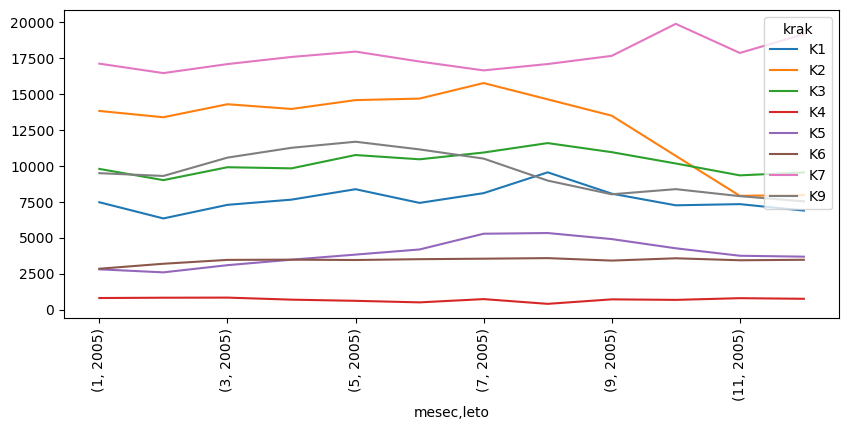

In [401]:
pd.set_option('display.precision', 2)
pivot = pd.crosstab([samo_kraki['mesec'], samo_kraki['leto']], samo_kraki['krak'], samo_kraki['OA'], aggfunc='mean') 

fig, ax = plt.subplots(figsize=(10,4))

pivot.plot(ax=ax, rot=90)
pivot

## statistike

??